**Objetivo del modelo:**
El objetivo del modelo es identificar los factores que influyen en la contratación de depósitos y evaluar su capacidad para priorizar clientes en campañas comerciales.

# 1. Importación librerías

In [42]:
# Manipulación y análisis de datos
import pandas as pd
import numpy as np


# Visualización de datos
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Preprocesamiento de datos y ML
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluacion
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor

import Funciones_TFM as fun

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 2. Carga del dataset

In [43]:
df = pd.read_csv("dataset_modelo.csv")

In [44]:
# Transformación de la variable "y" a binaria
df['y_bin'] = df['y'].map({"no": 0, "yes": 1})

In [45]:
df["previous_group"] = df["previous_group"].astype(str).str.strip()

# 3. Selección inicial de variables

## 3.1 Análisis univariante (Cramer's V)

In [46]:
variables_a_analizar = [
    "age_group",
    "job",
    "education_group",
    "marital",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "campaign_group",
    "duration_group",
    "pdays_group",
    "previous_group",
     "poutcome",
]

tabla_resultados = fun.tabla_chi2_cramersv(
    df=df,
    target="y",
    variables=variables_a_analizar
)

tabla_resultados

,variable,chi2_p_value,cramers_v
11,duration_group,0.0000,0.344
12,pdays_group,0.0000,0.325
14,poutcome,0.0000,0.321
8,month,0.0000,0.275
13,previous_group,0.0000,0.236
0,age_group,0.0000,0.167
1,job,0.0000,0.153
7,contact,0.0000,0.145
4,default,0.0000,0.099
10,campaign_group,0.0000,0.066


**Conclusión:**

Aunque algunas variables presentan asociación estadísticamente significativa en el análisis univariante (Cramér’s V), su contribución marginal en el modelo multivariante fue limitada.

- `housing` y `loan` presentan asociación prácticamente nula (Cramer's V <0.02)
- `day_of_week` muestra una asociación muy débil y no mejora el rendimiento predictivo
- `default` aunque presenta asociación moderada en análisis univariante, presenta una distribución altamente desbalanceada, con un número extremadamente reducido de casos positivos. Esto puede generar estimaciones inestables y coeficientes poco robustos en el modelo.
- `duration` dado que la información de la variable solo está disponible una vez realizado el contacto, incluirla introduciría un sesgo temporal al utilizar información posterior al evento de decisión. El objetivo es mantener un enfoque realista de priorización previa al contacto.

Por ello se decidió eliminarlas para reducir la complejidad, mejorar la interpretabilidad y minimizar overfitting innecesario.

## 3.2 Multicolinealidad (macro)

In [52]:
# Análisis variables macroeconómicas
macro_cols = ["euribor3m", "emp.var.rate", "nr.employed", "cons.price.idx", "cons.conf.idx"]

# 1) Dataset solo con macros
X_macro = df[macro_cols].copy()

# 2) Limpieza: infinitos y NaNs (rellenamos con mediana para no perder filas)
X_macro = X_macro.replace([np.inf, -np.inf], np.nan)
X_macro = X_macro.fillna(X_macro.median(numeric_only=True))

# 3) Escalado (recomendado para estabilidad numérica)
scaler = StandardScaler()
X_macro_scaled = pd.DataFrame(
    scaler.fit_transform(X_macro),
    columns=macro_cols
)

# 4) Cálculo VIF (sin const, VIF se calcula entre features)
vif_df = pd.DataFrame({
    "feature": macro_cols,
    "VIF": [variance_inflation_factor(X_macro_scaled.values, i) for i in range(X_macro_scaled.shape[1])]
}).sort_values("VIF", ascending=False)

vif_df

,feature,VIF
0,euribor3m,63.860354
1,emp.var.rate,32.897863
2,nr.employed,30.743930
3,cons.price.idx,6.294354
4,cons.conf.idx,2.596859


In [55]:
# Media de variables macro por mes
macro_por_mes = df.groupby("month")[[
    "euribor3m",
    "emp.var.rate",
    "nr.employed",
    "cons.price.idx",
    "cons.conf.idx"
]].mean()

macro_por_mes

,euribor3m,emp.var.rate,nr.employed,cons.price.idx,cons.conf.idx
month,,,,,
apr,1.361047,-1.800000,5093.121437,93.119575,-46.273318
aug,4.300408,0.746940,5200.239330,93.311022,-35.597021
dec,0.865319,-2.846154,5031.895604,92.715363,-33.708791
jul,4.686026,1.159353,5214.089985,93.895109,-42.371209
jun,4.256908,0.688379,5197.493193,94.245402,-41.579428
mar,1.162745,-1.800000,5055.390110,93.097330,-42.650549
may,3.293696,-0.164945,5149.522242,93.528894,-40.579168
nov,3.723018,-0.418561,5173.025683,93.200944,-41.238561
oct,1.200762,-2.437238,5018.825662,93.176145,-34.591632


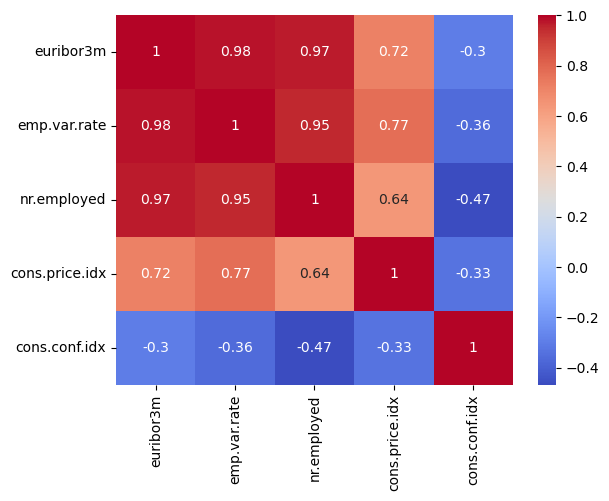

In [56]:
# Heatmap variables macroeconómicas con month
sns.heatmap(macro_por_mes.corr(), annot=True, cmap="coolwarm")
plt.show()

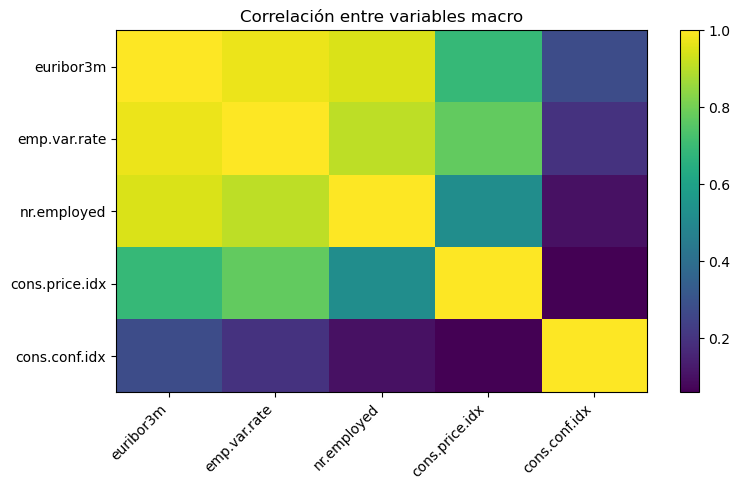

In [57]:
plt.figure(figsize=(8,5))
plt.imshow(corr_macro, aspect="auto")
plt.xticks(range(len(macro_cols)), macro_cols, rotation=45, ha="right")
plt.yticks(range(len(macro_cols)), macro_cols)
plt.colorbar()
plt.title("Correlación entre variables macro")
plt.tight_layout()
plt.show()

**Multicolinealidad (variables macroeconómicas)**

Se evaluó la colinealidad entre variables macro (`euribor3m`, `emp.var.rate`, `nr.employed`, `cons.price.idx`, `cons.conf.idx`) mediante **matriz de correlación y VIF**. 
Se observa una correlación extremadamente alta entre `euribor3m`, `emp.var.rate` y `nr.employed` **(r > 0.95)**, indicando redundancia informativa.

El análisis de VIF confirma multicolinealidad severa:
- `euribor3m`: VIF = 63.86
- `emp.var.rate`: VIF = 32.90
- `nr.employed`: VIF = 30.74

Dado que valores de VIF superiores a 10 indican colinealidad crítica, se decidió mantener únicamente `euribor3m` como proxy del entorno macroeconómico, eliminando el resto de variables macro para mejorar la estabilidad e interpretabilidad del modelo.

# 4. Preparación de los datos

## 4.1 Codificación

In [5]:
cols_modelo = [
    "y_bin",
    "age_group",
    "job",
    "marital",
    "education_group",
    "contact",
    "campaign_group",
    "poutcome",
    "month",
    "euribor3m"

]

df_model = df[cols_modelo].copy()

In [12]:
cat_cols = [
    "age_group",
    "campaign_group",
    "job",
    "marital",
    "month",
    "education_group",
    "contact",
    "poutcome",
]

# Convertimos las columnas categóricas a variables dummy
df_model_dum = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

## 4.2 Train / Test split

In [13]:
# Separamos variables (features) de la variable target y ("y")
X = df_model_dum.drop("y_bin", axis=1)
y = df_model_dum["y_bin"]

In [69]:
# Dividimos los datos en conjuntos de entrenamiento y test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 4.3 Escalado

In [ ]:
num_cols = ["euribor3m"]

# Copias para evitar warnings
X_train = X_train.copy()
X_test  = X_test.copy()

# 1) Fillna: calcula la mediana SOLO en train
medianas = X_train[num_cols].median()

#X_train.loc[:, num_cols] = X_train[num_cols].fillna(medianas)
X_test.loc[:, num_cols]  = X_test[num_cols].fillna(medianas)  # usamos las medianas de train

# 2) Escalado: fit SOLO en train
scaler = StandardScaler()
X_train.loc[:, num_cols] = scaler.fit_transform(X_train[num_cols])
X_test.loc[:, num_cols]  = scaler.transform(X_test[num_cols])

In [71]:
# Comparación: Baseline (class_weight) vs SMOTE
from imblearn.over_sampling import SMOTE

# 1) Baseline: Logistic Regression con class_weight balanced (sin SMOTE)
baseline = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
baseline.fit(X_train, y_train)

y_prob_test_base = baseline.predict_proba(X_test)[:, 1]
y_pred_test_base = (y_prob_test_base >= 0.5).astype(int)

auc_test_base = roc_auc_score(y_test, y_prob_test_base)

print("===== BASELINE (class_weight='balanced') =====")
print(f"AUC TEST: {auc_test_base:.4f}")
print(classification_report(y_test, y_pred_test_base))
print(confusion_matrix(y_test, y_pred_test_base))


# 2) SMOTE: oversampling SOLO en train
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

smote_model = LogisticRegression(max_iter=1000, random_state=42)
smote_model.fit(X_train_sm, y_train_sm)

y_prob_test_smote = smote_model.predict_proba(X_test)[:, 1]
y_pred_test_smote = (y_prob_test_smote >= 0.5).astype(int)

auc_test_smote = roc_auc_score(y_test, y_prob_test_smote)

print("\n===== SMOTE (solo en TRAIN) =====")
print(f"AUC TEST: {auc_test_smote:.4f}")
print(classification_report(y_test, y_pred_test_smote))
print(confusion_matrix(y_test, y_pred_test_smote))


# 3) Resumen comparativo rápido
print("\n===== RESUMEN =====")
print(f"AUC TEST Baseline: {auc_test_base:.4f}")
print(f"AUC TEST SMOTE   : {auc_test_smote:.4f}")

===== BASELINE (class_weight='balanced') =====
AUC TEST: 0.7939
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      7308
           1       0.33      0.68      0.44       928

    accuracy                           0.81      8236
   macro avg       0.64      0.75      0.66      8236
weighted avg       0.88      0.81      0.83      8236

[[6007 1301]
 [ 294  634]]

===== SMOTE (solo en TRAIN) =====
AUC TEST: 0.7714
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      7308
           1       0.30      0.63      0.40       928

    accuracy                           0.79      8236
   macro avg       0.62      0.72      0.64      8236
weighted avg       0.87      0.79      0.82      8236

[[5926 1382]
 [ 343  585]]

===== RESUMEN =====
AUC TEST Baseline: 0.7939
AUC TEST SMOTE   : 0.7714


# 5. Modelo

## 5.1 Regresión logística

In [72]:
# Creamos una instancia del modelo de regresión logística
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")

# Entrenamos el modelo
log_reg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

### 5.1.2 Classification report

In [73]:
# Entorno TEST
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

print("=== TEST ===")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

=== TEST ===
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      7308
           1       0.33      0.68      0.44       928

    accuracy                           0.81      8236
   macro avg       0.64      0.75      0.66      8236
weighted avg       0.88      0.81      0.83      8236

[[6007 1301]
 [ 294  634]]


In [74]:
# Probabilidades en TRAIN y TEST
y_prob_train = log_reg.predict_proba(X_train)[:, 1]
y_prob_test  = log_reg.predict_proba(X_test)[:, 1]

# AUC (siempre con probabilidades, no con y_pred)
auc_train = roc_auc_score(y_train, y_prob_train)
auc_test  = roc_auc_score(y_test, y_prob_test)

print(f"AUC TRAIN: {auc_train:.4f}")
print(f"AUC TEST : {auc_test:.4f}")

AUC TRAIN: 0.7890
AUC TEST : 0.7939


In [75]:
# Entorno TRAIN
y_pred_train = log_reg.predict(X_train)
y_prob_train = log_reg.predict_proba(X_train)[:, 1]

print("=== TRAIN ===")
print(classification_report(y_train, y_pred_train))
print(confusion_matrix(y_train, y_pred_train))


=== TRAIN ===
              precision    recall  f1-score   support

           0       0.95      0.82      0.88     29229
           1       0.31      0.65      0.42      3711

    accuracy                           0.80     32940
   macro avg       0.63      0.73      0.65     32940
weighted avg       0.88      0.80      0.83     32940

[[23897  5332]
 [ 1297  2414]]


# 6. Análisis de umbrales

In [76]:
# Umbrales a probar
thresholds = [0.50, 0.45, 0.40, 0.35, 0.30, 0.25]

rows = []
for t in thresholds:
    y_pred_t = (y_prob_test >= t).astype(int)
    
    prec = precision_score(y_test, y_pred_t, zero_division=0)
    rec  = recall_score(y_test, y_pred_t, zero_division=0)
    f1   = f1_score(y_test, y_pred_t, zero_division=0)
    acc  = accuracy_score(y_test, y_pred_t)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    
    rows.append({
        "threshold": t,
        "precision_1": prec,
        "recall_1": rec,
        "f1_1": f1,
        "accuracy": acc,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn
    })

results = pd.DataFrame(rows).sort_values("threshold", ascending=False)
results

,threshold,precision_1,recall_1,f1_1,accuracy,TP,FP,FN,TN
0,0.50,0.327649,0.683190,0.442892,0.806338,634,1301,294,6007
1,0.45,0.284197,0.720905,0.407678,0.763963,669,1685,259,5623
2,0.40,0.247059,0.746767,0.371283,0.715032,693,2112,235,5196
3,0.35,0.189703,0.806034,0.307124,0.590214,748,3195,180,4113
4,0.30,0.148209,0.878233,0.253618,0.417557,815,4684,113,2624
5,0.25,0.134188,0.936422,0.234738,0.312045,869,5607,59,1701


# 7. Evaluación de técnicas de balanceo

## 7.1 Comparación baseline vs SMOTE

In [77]:
# Comparación: Baseline (class_weight) vs SMOTE
from imblearn.over_sampling import SMOTE

# 1) Baseline: Logistic Regression con class_weight balanced (sin SMOTE)
baseline = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
baseline.fit(X_train, y_train)

y_prob_test_base = baseline.predict_proba(X_test)[:, 1]
y_pred_test_base = (y_prob_test_base >= 0.5).astype(int)

auc_test_base = roc_auc_score(y_test, y_prob_test_base)

print("===== BASELINE (class_weight='balanced') =====")
print(f"AUC TEST: {auc_test_base:.4f}")
print(classification_report(y_test, y_pred_test_base))
print(confusion_matrix(y_test, y_pred_test_base))


# 2) SMOTE: oversampling SOLO en train
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

smote_model = LogisticRegression(max_iter=1000, random_state=42)
smote_model.fit(X_train_sm, y_train_sm)

y_prob_test_smote = smote_model.predict_proba(X_test)[:, 1]
y_pred_test_smote = (y_prob_test_smote >= 0.5).astype(int)

auc_test_smote = roc_auc_score(y_test, y_prob_test_smote)

print("\n===== SMOTE (solo en TRAIN) =====")
print(f"AUC TEST: {auc_test_smote:.4f}")
print(classification_report(y_test, y_pred_test_smote))
print(confusion_matrix(y_test, y_pred_test_smote))


# 3) Resumen comparativo rápido
print("\n===== RESUMEN =====")
print(f"AUC TEST Baseline: {auc_test_base:.4f}")
print(f"AUC TEST SMOTE   : {auc_test_smote:.4f}")

===== BASELINE (class_weight='balanced') =====
AUC TEST: 0.7939
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      7308
           1       0.33      0.68      0.44       928

    accuracy                           0.81      8236
   macro avg       0.64      0.75      0.66      8236
weighted avg       0.88      0.81      0.83      8236

[[6007 1301]
 [ 294  634]]

===== SMOTE (solo en TRAIN) =====
AUC TEST: 0.7714
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      7308
           1       0.30      0.63      0.40       928

    accuracy                           0.79      8236
   macro avg       0.62      0.72      0.64      8236
weighted avg       0.87      0.79      0.82      8236

[[5926 1382]
 [ 343  585]]

===== RESUMEN =====
AUC TEST Baseline: 0.7939
AUC TEST SMOTE   : 0.7714


# 8. Interpretación de coeficientes

## 8.1 Coeficientes y odds

In [78]:
# Coeficientes y odds
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef_log_odds": log_reg.coef_[0]
})

coef_df["odds_ratio"] = np.exp(coef_df["coef_log_odds"])

coef_df = coef_df.sort_values(by="coef_log_odds", ascending=False)

coef_df.head(10)

,feature,coef_log_odds,odds_ratio
37,poutcome_success,1.994752,7.350378
27,month_mar,1.157485,3.181921
30,month_oct,1.084353,2.957526
24,month_dec,0.810914,2.249965
31,month_sep,0.521161,1.683982
25,month_jul,0.462788,1.588496
36,poutcome_nonexistent,0.399769,1.491480
4,age_group_66+,0.397952,1.488772
26,month_jun,0.314706,1.369857
23,month_aug,0.264204,1.302394


## 8.2 Tabla factores top positivos

In [79]:
# Factores que empujan al YES
top_yes = coef_df[coef_df["coef_log_odds"] > 0].head(25)
top_yes

,feature,coef_log_odds,odds_ratio
37,poutcome_success,1.994752,7.350378
27,month_mar,1.157485,3.181921
30,month_oct,1.084353,2.957526
24,month_dec,0.810914,2.249965
31,month_sep,0.521161,1.683982
25,month_jul,0.462788,1.588496
36,poutcome_nonexistent,0.399769,1.491480
4,age_group_66+,0.397952,1.488772
26,month_jun,0.314706,1.369857
23,month_aug,0.264204,1.302394


## 8.3 Tabla factores top negativos

In [80]:
# Factores que empujan al NO
top_no = coef_df[coef_df["coef_log_odds"] < 0].sort_values(by="coef_log_odds").head(30)
top_no

,feature,coef_log_odds,odds_ratio
0,euribor3m,-0.777481,0.459562
28,month_may,-0.563931,0.568968
8,campaign_group_4+,-0.242020,0.785041
18,job_unemployed,-0.185638,0.830574
9,job_blue-collar,-0.152294,0.858736
1,age_group_36-45,-0.132792,0.875647
15,job_services,-0.129888,0.878194
32,education_group_low_education,-0.125680,0.881897
33,education_group_medium_education,-0.099734,0.905078
35,contact_telephone,-0.096166,0.908313


# 9. Análisis de priorización

## 9.1 Deciles

In [81]:
df_scores = X_test.copy()
df_scores["prob"] = y_prob
df_scores["real"] = y_test.values

df_scores["decile"] = pd.qcut(df_scores["prob"], 10, labels=False)

lift_table = df_scores.groupby("decile").agg(
    n=("real", "count"),
    conv=("real", "mean"),
    proba_mean=("prob", "mean")
).reset_index()

global_rate = df_scores["real"].mean()
lift_table["lift_vs_global"] = lift_table["conv"] / global_rate

lift_table.sort_values("decile", ascending=False)

,decile,n,conv,proba_mean,lift_vs_global
9,9,824,0.470874,0.854650,4.179005
8,8,823,0.257594,0.638897,2.286148
7,7,823,0.087485,0.486102,0.776428
6,6,824,0.061893,0.396725,0.549302
5,5,824,0.042476,0.358038,0.376972
4,4,823,0.041312,0.331952,0.366646
3,3,823,0.058323,0.304866,0.517618
2,2,824,0.040049,0.269208,0.355431
1,1,823,0.027947,0.178579,0.248026
0,0,825,0.038788,0.138292,0.344242


In [82]:
# 1) Base con verdad y probabilidad
df_rank = pd.DataFrame({
    "y_true": y_test.values if hasattr(y_test, "values") else y_test,
    "prob": y_prob_test
}).sort_values("prob", ascending=False).reset_index(drop=True)

total_clientes = len(df_rank)
total_conv = df_rank["y_true"].sum()
conv_global = total_conv / total_clientes

# 2) Crear deciles (Top decil = 10, peor decil = 1)
df_rank["decil"] = pd.qcut(df_rank.index, 10, labels=False)  # 0..9 (0 = top)
df_rank["decil"] = 10 - df_rank["decil"]                    # 10..1 (10 = top)

# 3) Métricas por decil (no acumuladas)
por_decil = (
    df_rank.groupby("decil")
    .agg(
        clientes=("y_true", "count"),
        contrataciones=("y_true", "sum"),
        prob_media=("prob", "mean"),
    )
    .sort_index(ascending=False)  # 10 -> 1
)

por_decil["tasa_conversion"] = por_decil["contrataciones"] / por_decil["clientes"]
por_decil["lift_vs_global"] = por_decil["tasa_conversion"] / conv_global

# 4) Acumulados desde el TOP hacia abajo
por_decil["clientes_acum"] = por_decil["clientes"].cumsum()
por_decil["contrataciones_acum"] = por_decil["contrataciones"].cumsum()

# 5) Porcentajes acumulados
por_decil["%base_contactada_acum"] = por_decil["clientes_acum"] / total_clientes
por_decil["%contrataciones_capturadas_acum"] = por_decil["contrataciones_acum"] / total_conv

# 6) Extras útiles para lectura
por_decil["conversion_global"] = conv_global
por_decil["%conversion_decil"] = por_decil["tasa_conversion"]  # alias más claro

# 7) Renombrar columnas para dashboard (clarito)
df_dashboard = por_decil.reset_index().rename(columns={
    "decil": "Decil (10=Top)",
    "clientes": "Clientes (decil)",
    "contrataciones": "Contrataciones (decil)",
    "tasa_conversion": "Conversión (decil)",
    "prob_media": "Prob. media (decil)",
    "lift_vs_global": "Lift vs global (decil)",
    "clientes_acum": "Clientes acumulados (Top→)",
    "contrataciones_acum": "Contrataciones acumuladas (Top→)",
    "%base_contactada_acum": "% base contactada (acum)",
    "%contrataciones_capturadas_acum": "% contrataciones capturadas (acum)",
    "conversion_global": "Conversión global"
})

df_dashboard

,Decil (10=Top),Clientes (decil),Contrataciones (decil),Prob. media (decil),Conversión (decil),Lift vs global (decil),Clientes acumulados (Top→),Contrataciones acumuladas (Top→),% base contactada (acum),% contrataciones capturadas (acum),Conversión global,%conversion_decil
0,10,824,388,0.854650,0.470874,4.179005,824,388,0.100049,0.418103,0.112676,0.470874
1,9,824,212,0.638782,0.257282,2.283374,1648,600,0.200097,0.646552,0.112676,0.257282
2,8,823,72,0.485964,0.087485,0.776428,2471,672,0.300024,0.724138,0.112676,0.087485
3,7,824,51,0.396655,0.061893,0.549302,3295,723,0.400073,0.779095,0.112676,0.061893
4,6,823,35,0.358019,0.042527,0.377430,4118,758,0.500000,0.816810,0.112676,0.042527
5,5,824,34,0.331937,0.041262,0.366201,4942,792,0.600049,0.853448,0.112676,0.041262
6,4,823,48,0.304829,0.058323,0.517618,5765,840,0.699976,0.905172,0.112676,0.058323
7,3,824,33,0.269138,0.040049,0.355431,6589,873,0.800024,0.940733,0.112676,0.040049
8,2,823,23,0.178486,0.027947,0.248026,7412,896,0.899951,0.965517,0.112676,0.027947
9,1,824,32,0.138272,0.038835,0.344660,8236,928,1.000000,1.000000,0.112676,0.038835


In [83]:
# Tabla de escenarios Top X% (acumulado)
escenarios = [0.05, 0.10, 0.15, 0.20, 0.30]

rows = []
for p in escenarios:
    k = int(np.ceil(total_clientes * p))
    top = df_rank.head(k)
    conv_top = top["y_true"].mean()
    capturadas = top["y_true"].sum()
    pct_capturadas = capturadas / total_conv
    lift = conv_top / conv_global

    rows.append({
        "Escenario": f"Top {int(p*100)}%",
        "Clientes contactados": k,
        "% base contactada": k / total_clientes,
        "Conversión en el grupo": conv_top,
        "Lift vs global": lift,
        "Contrataciones capturadas": int(capturadas),
        "% contrataciones capturadas": pct_capturadas
    })

df_escenarios = pd.DataFrame(rows)
df_escenarios

,Escenario,Clientes contactados,% base contactada,Conversión en el grupo,Lift vs global,Contrataciones capturadas,% contrataciones capturadas
0,Top 5%,412,0.050024,0.560680,4.976032,231,0.248922
1,Top 10%,824,0.100049,0.470874,4.179005,388,0.418103
2,Top 15%,1236,0.150073,0.435275,3.863066,538,0.579741
3,Top 20%,1648,0.200097,0.364078,3.231189,600,0.646552
4,Top 30%,2471,0.300024,0.271955,2.413598,672,0.724138


# 5. Preparación de dataframes para el Dashboard

In [88]:
# 1) Nos quedamos SOLO con las filas de test (mismo orden que y_test)
df_scored = X.loc[y_test.index].copy()

# 2) Añadimos verdad y probabilidad
df_scored["y_true"] = y_test.values if hasattr(y_test, "values") else y_test
df_scored["prob"]   = y_prob_test

# 3) Ordenamos por prob desc (Top primero)
df_scored = df_scored.sort_values("prob", ascending=False).reset_index(drop=False)
df_scored.rename(columns={"index":"row_id"}, inplace=True)

df_scored.head()

,row_id,euribor3m,age_group_36-45,age_group_46-55,age_group_56-65,age_group_66+,age_group_<=25,campaign_group_2,campaign_group_3,campaign_group_4+,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,education_group_low_education,education_group_medium_education,education_group_unknown,contact_telephone,poutcome_nonexistent,poutcome_success,y_true,prob
0,39319,0.639,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,True,0,0.987265
1,39122,0.655,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,1,0.986777
2,38168,0.752,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,1,0.985664
3,39135,0.655,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,1,0.985501
4,38304,0.740,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,1,0.985370


In [106]:
df_scored = df_scored.sort_values("prob", ascending=False).reset_index(drop=True)
n = len(df_scored)
df_scored["rank"] = np.arange(1, n+1)
df_scored["percentile"] = df_scored["rank"] / n

# ---- Escenarios acumulados ----
thresholds = [0.05, 0.10, 0.15, 0.20, 0.30]

conv_global = df_scored["y_true"].mean()
total_conv = int(df_scored["y_true"].sum())
total_clients = int(len(df_scored))

dfs = []
for t in thresholds:
    label = f"Top {int(t*100)}%"
    tmp = df_scored.copy()
    tmp["escenario"] = label
    tmp["threshold"] = t
    tmp["in_scenario"] = tmp["percentile"] <= t  # ✅ acumulado real

    # KPIs del escenario (constantes repetidas por fila)
    k = int(np.ceil(total_clients * t))
    top = df_scored.head(k)

    conv_top = top["y_true"].mean()
    capturadas = int(top["y_true"].sum())
    pct_capturadas = capturadas / total_conv if total_conv > 0 else np.nan
    lift = conv_top / conv_global if conv_global > 0 else np.nan

    tmp["kpi_clientes_contactados"] = k
    tmp["kpi_pct_base_contactada"] = k / total_clients
    tmp["kpi_conversion_en_grupo"] = conv_top
    tmp["kpi_contrataciones_capturadas"] = capturadas
    tmp["kpi_pct_contrataciones_capturadas"] = pct_capturadas
    tmp["kpi_lift_vs_global"] = lift
    tmp["kpi_conv_global"] = conv_global
    tmp["kpi_total_conv"] = total_conv
    tmp["kpi_total_clients"] = total_clients

    dfs.append(tmp)

df_acumulado = pd.concat(dfs, ignore_index=True)
df_acumulado.to_csv("df_dashboard_acumulado.csv", index=False)


In [26]:
# Clasificación de variables por segmentos
def clasificar_variable(nombre):
    if any(x in nombre for x in ["euribor"]):
        return "Macro"
    elif "month_" in nombre:
        return "Estacional"
    elif any(x in nombre for x in ["age_group", "job", "marital", "education_group"]):
        return "Demográfica"
    elif any(x in nombre for x in ["poutcome", "campaign_group", "contact"]):
        return "Operativa"
    else:
        return "Otros"

coef_df["tipo_variable"] = coef_df["feature"].apply(clasificar_variable)


In [109]:
df_scored["percentile"].min(), df_scored["percentile"].max()

(0.00012141816415735794, 1.0)

In [27]:
coef_df.to_csv("modelo_completo_coeficientes.csv", index=False)


In [28]:
# Classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# AUC
auc = roc_auc_score(y_test, y_prob)

# Especificidad
specificity = tn / (tn + fp)

metricas_df = pd.DataFrame({
    "metric": [
        "accuracy",
        "precision_yes",
        "recall_yes",
        "f1_yes",
        "specificity",
        "auc",
        "true_negatives",
        "false_positives",
        "false_negatives",
        "true_positives"
    ],
    "value": [
        report["accuracy"],
        report["1"]["precision"],
        report["1"]["recall"],
        report["1"]["f1-score"],
        specificity,
        auc,
        tn,
        fp,
        fn,
        tp
    ]
})

metricas_df.to_csv("modelo_completo_metricas_test.csv", index=False)

metricas_df

,metric,value
0,accuracy,0.806338
1,precision_yes,0.327649
2,recall_yes,0.683190
3,f1_yes,0.442892
4,specificity,0.821976
5,auc,0.793944
6,true_negatives,6007.000000
7,false_positives,1301.000000
8,false_negatives,294.000000
9,true_positives,634.000000


In [29]:
# Classification report TRAIN
report = classification_report(y_train, y_pred_train, output_dict=True)

# Matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()

# AUC
auc = roc_auc_score(y_train, y_pred_train)

# Especificidad
specificity = tn / (tn + fp)

metricas_df_train = pd.DataFrame({
    "metric": [
        "accuracy",
        "precision_yes",
        "recall_yes",
        "f1_yes",
        "specificity",
        "auc",
        "true_negatives",
        "false_positives",
        "false_negatives",
        "true_positives"
    ],
    "value": [
        report["accuracy"],
        report["1"]["precision"],
        report["1"]["recall"],
        report["1"]["f1-score"],
        specificity,
        auc,
        tn,
        fp,
        fn,
        tp
    ]
})

metricas_df_train.to_csv("modelo_completo_metricas_train.csv", index=False)

metricas_df_train

,metric,value
0,accuracy,0.798755
1,precision_yes,0.311645
2,recall_yes,0.650499
3,f1_yes,0.421402
4,specificity,0.817578
5,auc,0.734038
6,true_negatives,23897.000000
7,false_positives,5332.000000
8,false_negatives,1297.000000
9,true_positives,2414.000000


In [31]:
# Dataframe classification report entorno TRAIN y TEST

# Filtramos solo las métricas que queremos comparar
metrics_to_compare = ["accuracy", "precision_yes", "recall_yes", "specificity", "auc"]

train_filtered = metricas_df_train[metricas_df_train["metric"].isin(metrics_to_compare)].copy()
test_filtered = metricas_df[metricas_df["metric"].isin(metrics_to_compare)].copy()

# Renombramos columna value
train_filtered = train_filtered.rename(columns={"value": "train_value"})
test_filtered = test_filtered.rename(columns={"value": "test_value"})

# Merge
df_comparison = train_filtered.merge(
    test_filtered[["metric", "test_value"]],
    on="metric",
    how="inner"
)

df_comparison.to_csv("modelo_completo_metricas_train_test.csv", index=False)
df_comparison

,metric,train_value,test_value
0,accuracy,0.798755,0.806338
1,precision_yes,0.311645,0.327649
2,recall_yes,0.650499,0.683190
3,specificity,0.817578,0.821976
4,auc,0.734038,0.793944


In [62]:
# Exportar a CSV para el dashboard
df_escenarios.to_csv("dashboard_escenarios.csv", index=False)
df_dashboard.to_csv("dashboard_deciles.csv", index=False)

print("Generados: dashboard_escenarios.csv y dashboard_deciles.csv")

Generados: dashboard_escenarios.csv y dashboard_deciles.csv


In [63]:
metricas_df.to_csv("modelo_completo_metricas.csv", index=False)

In [65]:
df_scoring = df.loc[X_test.index, ["age_group","job","marital","education_group","campaign_group","poutcome","month","contact"]].copy()
df_scoring["prob_modelo"] = y_prob
df_scoring["y_real"] = y_test.values

df_scoring.columns = [c.replace(".", "_").replace(" ", "_") for c in df_scoring.columns]
df_scoring.to_csv("modelo_completo_scoring.csv", index=False)




In [ ]:
# ==========================
# 0) PRE-REQUISITOS (DEBEN EXISTIR YA)
# ==========================
# - X_test : DataFrame (features ya dummificadas, mismas columnas que el train)
# - y_test : Series (0/1)  -> solo si estás en histórico/test
# - y_prob : array (probabilidades del modelo en X_test, clase 1)
#
# Si no tienes y_prob:
# y_prob = log_reg.predict_proba(X_test)[:, 1]

# ==========================
# 1) CREAR client_id (para el subset que vas a exportar)
# ==========================
# Como tú no tienes client_id, lo creamos SOLO para X_test:
scoring_df = X_test.copy()
scoring_df = scoring_df.reset_index(drop=True)  # index limpio
scoring_df["client_id"] = np.arange(1, len(scoring_df) + 1)

# ==========================
# 2) AÑADIR PROBABILIDAD + (OPCIONAL) y_real
# ==========================
scoring_df["prob_modelo"] = y_prob

# Si tienes y_test (histórico), lo metemos para validar conversion real por top%
if "y_test" in globals() or "y_test" in locals():
    scoring_df["y_real"] = y_test.reset_index(drop=True)

# ==========================
# 3) DECILES (si ya los tienes, puedes saltarte esto)
# ==========================
# Decil 10 = más probabilidad
scoring_df["decil"] = pd.qcut(scoring_df["prob_modelo"], 10, labels=False, duplicates="drop") + 1
scoring_df["decil"] = scoring_df["decil"].astype(int)

# Ordenamos de mayor a menor probabilidad (lista priorizada)
scoring_df = scoring_df.sort_values("prob_modelo", ascending=False).reset_index(drop=True)

# ==========================
# 4) FLAGS TOP% (para listas operativas)
# ==========================
TOP_PCTS = [0.05, 0.10, 0.20, 0.30]
N = len(scoring_df)

for p in TOP_PCTS:
    k = int(np.ceil(N * p))
    col_flag = f"es_top_{int(p*100)}"
    scoring_df[col_flag] = 0
    scoring_df.loc[:k-1, col_flag] = 1

# ==========================
# 5) EXPORTS CSV (LISTOS PARA EQUIPO)
# ==========================
# A) scoring completo (para dashboard o revisión)
cols_export = ["client_id", "prob_modelo", "decil"] + [f"es_top_{int(p*100)}" for p in TOP_PCTS]
if "y_real" in scoring_df.columns:
    cols_export += ["y_real"]

scoring_df[cols_export].to_csv("modelo_scoring_completo_test.csv", index=False)

# B) listas por top%
for p in TOP_PCTS:
    k = int(np.ceil(N * p))
    df_top = scoring_df.head(k)[cols_export].copy()
    df_top.to_csv(f"clientes_top_{int(p*100)}_test.csv", index=False)

print("✅ Exportados:")
print("- modelo_scoring_completo_test.csv")
for p in TOP_PCTS:
    print(f"- clientes_top_{int(p*100)}_test.csv")

# ==========================
# 6) (OPCIONAL) KPI DE LIFT POR TOP% (si tienes y_real)
# ==========================
if "y_real" in scoring_df.columns:
    base_rate = scoring_df["y_real"].mean()
    print(f"\n📌 Conversión media en TEST: {base_rate:.4f}")
    for p in TOP_PCTS:
        k = int(np.ceil(N * p))
        conv_top = scoring_df.head(k)["y_real"].mean()
        lift = conv_top / base_rate if base_rate > 0 else np.nan
        print(f"Top {int(p*100)}% -> conv_real={conv_top:.4f} | lift={lift:.2f}x | n={k}")


✅ Exportados:
- modelo_scoring_completo_test.csv
- clientes_top_5_test.csv
- clientes_top_10_test.csv
- clientes_top_20_test.csv
- clientes_top_30_test.csv

📌 Conversión media en TEST: 0.1127
Top 5% -> conv_real=0.5607 | lift=4.98x | n=412
Top 10% -> conv_real=0.4709 | lift=4.18x | n=824
Top 20% -> conv_real=0.3641 | lift=3.23x | n=1648
Top 30% -> conv_real=0.2720 | lift=2.41x | n=2471


In [66]:
scoring_df[scoring_df["es_top_20"] == 1].head()


NameError: name 'scoring_df' is not defined

In [36]:
scoring_df[scoring_df["es_top_20"] == 1].head()


,euribor3m,age_group_36-45,age_group_46-55,age_group_56-65,age_group_66+,age_group_<=25,campaign_group_2,campaign_group_3,campaign_group_4+,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,education_group_low_education,education_group_medium_education,education_group_unknown,contact_telephone,poutcome_nonexistent,poutcome_success,client_id,prob_modelo,y_real,decil,es_top_5,es_top_10,es_top_20,es_top_30
0,-1.716139,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,True,2054,0.987265,0,10,1,1,1,1
1,-1.706922,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,5854,0.986777,1,10,1,1,1,1
2,-1.651043,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,4457,0.985664,1,10,1,1,1,1
3,-1.706922,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,3619,0.985501,1,10,1,1,1,1
4,-1.657956,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,4704,0.985370,1,10,1,1,1,1


In [37]:
scoring_df.sort_values("prob_modelo", ascending=False).head(10)


,euribor3m,age_group_36-45,age_group_46-55,age_group_56-65,age_group_66+,age_group_<=25,campaign_group_2,campaign_group_3,campaign_group_4+,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,education_group_low_education,education_group_medium_education,education_group_unknown,contact_telephone,poutcome_nonexistent,poutcome_success,client_id,prob_modelo,y_real,decil,es_top_5,es_top_10,es_top_20,es_top_30
0,-1.716139,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,True,2054,0.987265,0,10,1,1,1,1
1,-1.706922,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,5854,0.986777,1,10,1,1,1,1
2,-1.651043,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,4457,0.985664,1,10,1,1,1,1
3,-1.706922,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,3619,0.985501,1,10,1,1,1,1
4,-1.657956,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,4704,0.985370,1,10,1,1,1,1
5,-1.664869,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,5764,0.984203,1,10,1,1,1,1
6,-1.708074,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,7056,0.984180,0,10,1,1,1,1
7,-1.674086,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,5570,0.984163,1,10,1,1,1,1
8,-1.518547,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,4650,0.983982,1,10,1,1,1,1
9,-1.508178,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,5484,0.983112,0,10,1,1,1,1


In [38]:
base = scoring_df["y_real"].mean()
for p in [0.01, 0.05, 0.10]:
    k = int(len(scoring_df) * p)
    conv = scoring_df.head(k)["y_real"].mean()
    print(p, "conv:", conv, "lift:", conv/base)


0.01 conv: 0.7073170731707317 lift: 6.277439024390244
0.05 conv: 0.559610705596107 lift: 4.96654501216545
0.1 conv: 0.47144592952612396 lift: 4.18408262454435


In [39]:
def analizar_top_percent(percent):
    
    # Número de clientes a incluir
    n_clientes = int(len(scoring_df) * percent)
    
    # Ordenamos por probabilidad descendente
    df_sorted = scoring_df.sort_values("prob_modelo", ascending=False)
    
    # Seleccionamos top X%
    df_top = df_sorted.head(n_clientes)
    
    # Métricas
    yes_capturados = df_top["y_real"].sum()
    yes_totales = scoring_df["y_real"].sum()
    yes_escapados = yes_totales - yes_capturados
    
    conversion_top = yes_capturados / n_clientes
    recall_efectivo = yes_capturados / yes_totales
    
    print(f"\n=== TOP {int(percent*100)}% ===")
    print("Clientes llamados:", n_clientes)
    print("YES capturados:", yes_capturados)
    print("YES escapados:", yes_escapados)
    print("Conversión en ese segmento:", round(conversion_top,3))
    print("Recall efectivo:", round(recall_efectivo,3))


In [40]:
analizar_top_percent(0.05)
analizar_top_percent(0.10)
analizar_top_percent(0.15)
analizar_top_percent(0.20)
analizar_top_percent(0.30)



=== TOP 5% ===
Clientes llamados: 411
YES capturados: 230
YES escapados: 698
Conversión en ese segmento: 0.56
Recall efectivo: 0.248

=== TOP 10% ===
Clientes llamados: 823
YES capturados: 388
YES escapados: 540
Conversión en ese segmento: 0.471
Recall efectivo: 0.418

=== TOP 15% ===
Clientes llamados: 1235
YES capturados: 538
YES escapados: 390
Conversión en ese segmento: 0.436
Recall efectivo: 0.58

=== TOP 20% ===
Clientes llamados: 1647
YES capturados: 600
YES escapados: 328
Conversión en ese segmento: 0.364
Recall efectivo: 0.647

=== TOP 30% ===
Clientes llamados: 2470
YES capturados: 672
YES escapados: 256
Conversión en ese segmento: 0.272
Recall efectivo: 0.724


In [41]:
# ¿Cuántos YES adicionales capturo por cada llamada adicional?
def marginal_gain(p1, p2):
    df_sorted = scoring_df.sort_values("prob_modelo", ascending=False)

    n1 = int(len(df_sorted) * p1)
    n2 = int(len(df_sorted) * p2)

    tramo = df_sorted.iloc[n1:n2].copy()
    llamadas = len(tramo)
    yes_extra = tramo["y_real"].sum()
    conv_marginal = yes_extra / llamadas if llamadas > 0 else 0

    print(f"\n=== Tramo {int(p1*100)}% → {int(p2*100)}% ===")
    print("Llamadas extra:", llamadas)
    print("YES extra:", yes_extra)
    print("Conversión marginal del tramo:", round(conv_marginal,3))

marginal_gain(0.05, 0.10)
marginal_gain(0.10, 0.15)
marginal_gain(0.15, 0.20)




=== Tramo 5% → 10% ===
Llamadas extra: 412
YES extra: 158
Conversión marginal del tramo: 0.383

=== Tramo 10% → 15% ===
Llamadas extra: 412
YES extra: 150
Conversión marginal del tramo: 0.364

=== Tramo 15% → 20% ===
Llamadas extra: 412
YES extra: 62
Conversión marginal del tramo: 0.15


In [42]:
import pandas as pd
import numpy as np

TOP_PCTS = [0.05, 0.10, 0.15, 0.20, 0.30]

# Asegúrate de ordenar por probabilidad DESC antes (si no lo hiciste ya)
scoring_df = scoring_df.sort_values("prob_modelo", ascending=False).reset_index(drop=True)

base_rate = scoring_df["y_real"].mean()
N = len(scoring_df)
total_yes = scoring_df["y_real"].sum()

escenarios = []

# Global
escenarios.append({
    "escenario": "Global",
    "pct_base_contactada": 1.0,
    "clientes_llamados": int(N),
    "conversion": float(base_rate),
    "lift_vs_global": 1.0,
    "pct_conversiones_capturadas": 1.0,
    "cierres_por_100": float(base_rate * 100)
})

# Escenarios Top
for p in TOP_PCTS:
    k = int(np.ceil(N * p))
    df_top = scoring_df.head(k)

    conv = df_top["y_real"].mean()
    lift = conv / base_rate if base_rate > 0 else np.nan
    pct_capturadas = df_top["y_real"].sum() / total_yes if total_yes > 0 else np.nan

    escenarios.append({
        "escenario": f"Top {int(p*100)}%",
        "pct_base_contactada": float(p),
        "clientes_llamados": int(k),
        "conversion": float(conv),
        "lift_vs_global": float(lift),
        "pct_conversiones_capturadas": float(pct_capturadas),
        "cierres_por_100": float(conv * 100)
    })

df_escenarios = pd.DataFrame(escenarios)

# Tipos explícitos (para que Looker lo detecte como número)
df_escenarios = df_escenarios.astype({
    "pct_base_contactada": "float64",
    "clientes_llamados": "int64",
    "conversion": "float64",
    "lift_vs_global": "float64",
    "pct_conversiones_capturadas": "float64",
    "cierres_por_100": "float64",
})

df_escenarios.to_csv("escenarios_modelo_TFM.csv", index=False)
df_escenarios



,escenario,pct_base_contactada,clientes_llamados,conversion,lift_vs_global,pct_conversiones_capturadas,cierres_por_100
0,Global,1.00,8236,0.112676,1.000000,1.000000,11.267606
1,Top 5%,0.05,412,0.560680,4.976032,0.248922,56.067961
2,Top 10%,0.10,824,0.470874,4.179005,0.418103,47.087379
3,Top 15%,0.15,1236,0.435275,3.863066,0.579741,43.527508
4,Top 20%,0.20,1648,0.364078,3.231189,0.646552,36.407767
5,Top 30%,0.30,2471,0.271955,2.413598,0.724138,27.195467


In [43]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")


AUC: 0.7939


In [44]:
df_sorted = df_scoring.sort_values("prob_modelo", ascending=False).reset_index(drop=True)

df_sorted["pct_acumulado"] = (df_sorted.index + 1) / len(df_sorted)

df_sorted["yes_acum"] = df_sorted["y_real"].cumsum()

total_yes = df_sorted["y_real"].sum()

df_sorted["recall_acum"] = df_sorted["yes_acum"] / total_yes

df_sorted["conversion_acum"] = df_sorted["yes_acum"] / (df_sorted.index + 1)


In [45]:
curva_cols = ["pct_acumulado", "recall_acum", "conversion_acum", "prob_modelo", "yes_acum", "y_real"]

for c in curva_cols:
    df_sorted[c] = pd.to_numeric(df_sorted[c], errors="coerce")

df_sorted[curva_cols].dtypes


pct_acumulado      float64
recall_acum        float64
conversion_acum    float64
prob_modelo        float64
yes_acum             int64
y_real               int64
dtype: object

In [46]:
df_curva_looker = df_sorted[["pct_acumulado", "recall_acum", "conversion_acum"]].copy()
df_curva_looker.to_csv("curva_acumulada.csv", index=False)

